# 2D and 3D domains

Implement the learning of exercise-1 from day-1 to solve the non-linear Poisson's equation on 2D and 3D domains. Feel free to create the mesh of your preference for the problem.

- Download and install Paraview.
- Name the fields to be visualized. (To visualize a function in Paraview you have to name it in FEniCS. The way to do that is use the command `v.rename("name", "label")`)
- Write to XDMF the error and the solution.
- Visualize the error and solution in Paraview

Hint: Check day-1/tutorial-2 

In [1]:
from dolfin import *
import numpy

Update this mesh to a unit square mesh.

In [2]:

mesh = UnitSquareMesh(32, 32)

In [3]:
V = FunctionSpace(mesh, 'Lagrange', 1)

left_boundary = CompiledSubDomain("on_boundary && near(x[0],0)")
right_boundary = CompiledSubDomain("on_boundary && near(x[0],1)")

bc_0 = DirichletBC(V, Constant(0.0), left_boundary)
bc_1 = DirichletBC(V, Constant(1.0), right_boundary)
bcs = [bc_0, bc_1]

m = 5


def q(u):
    return (1+u)**m

# Define variational problem
v = TestFunction(V)
du = TrialFunction(V)
u = Function(V)  # most recently computed solution
F = inner(q(u)*nabla_grad(u), nabla_grad(v))*dx

J = derivative(F, u, du)

# Compute solution
problem = NonlinearVariationalProblem(F, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-5
prm['newton_solver']['relative_tolerance'] = 1E-5
prm['newton_solver']['maximum_iterations'] = 25

solver.solve()

# Find max error
u_exact = Expression(
    'pow((pow(2, m+1)-1)*x[0] + 1, 1.0/(m+1)) - 1', m=m, degree=1)
u_e = interpolate(u_exact, V)
diff = numpy.abs(u_e.vector()[:] - u.vector()[:]).max()
print('Max error:{0:5.3e}'.format(diff))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Max error:4.953e-03


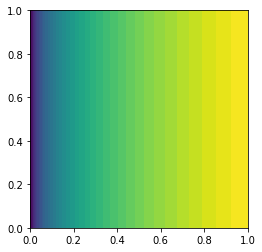

In [5]:
plot(u_e)

Export the error and solution vector to XDMF

In [6]:
with XDMFFile("output/result21.xdmf") as outfile:
    outfile.write(u_e)